In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import mylibrary.nnlib as tnn
import mylibrary.dynamicnnlib as tdnn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [3]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

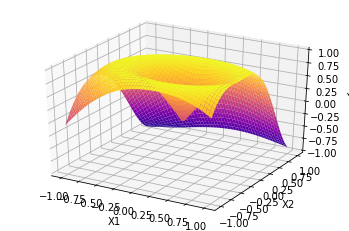

In [4]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [74]:
class PRelu(tnn.Layer):
    def __init__(self, io_dim, optimizer=tnn.SGD()):
        self.input = None
        self.output = None
        self.del_output = None
        
        self.alpha = np.ones(io_dim)
        self.alphaOpt = optimizer.set_parameter(self.alpha)
        self.delalpha = None
        
        tnn.layerList.append(self)

    def forward(self, input):
        self.input = input
        self.output = np.maximum(self.alpha*input, input)
        return self.output

    def backward(self, output_delta):
        self.del_output = output_delta
        self.delalpha = np.where(self.input >= 0, 0, self.input)*output_delta
        self.delalpha = self.delalpha.mean(axis=0)
        return np.where(self.input >= 0, 1, self.alpha)*output_delta
    
    def update(self):
        gradient = self.alphaOpt.compute_gradient(self.delalpha)
        self.alpha -= gradient
#         self.alpha = np.clip(self.alpha, 0, 1)
        self.alpha = np.maximum(0, self.alpha)
        
    def set_decay_rate(self, lamda=0.001):
        self.lamda = lamda
        
    def l1_weight_recover(self):
        self.alpha -= self.lamda*np.sign(self.alpha - 1)
#         self.alpha -= self.lamda*(self.alpha-1)
    
    def l1_weight_decay(self):
        self.alpha -= self.lamda*np.sign(self.alpha)
#         self.alpha -= self.lamda*self.alpha

In [75]:
optim = tnn.Adam()
net = tnn.AutoForm(new_layers=True)
layer1 = tnn.LinearLayer(2, 17, optimizer=optim)
# layer0 = tnn.WeightsLayer(2, 17, optimizer=optim)
# layer1 = tnn.BatchNormalization(17, optimizer=optim)
layer2 = PRelu(17, optimizer=optim)
layer3 = tnn.LinearLayer(17, 1, optimizer=optim)

In [76]:
layer2.set_decay_rate(0.001)
# layer2.alpha *= 0.

In [77]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

try:
    for epoch in range(100000):
#         layer1.multiplier.multiplier = layer1.multiplier.multiplier*0 + 0.5
#         layer1.weights /= np.linalg.norm(layer1.weights, ord=2, axis=0, keepdims=True)
#         if epoch%10 == 0:
        if epoch < 1000:
            layer2.l1_weight_decay()
        else:
            layer2.l1_weight_recover()

        yout = net.forward(xx)
        
        dy = yout - yy
        dx = net.backward(dy)

        layer3.update()
        layer1.update()
        layer0.update()

#         layer1.bias *= 0.
        layer2.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.4790021803424579
100 Error =  0.03794392003203482
200 Error =  0.017673943505228364
300 Error =  0.012441087935905273
400 Error =  0.010458398901388933
500 Error =  0.008945138470571348
600 Error =  0.007765634251064529
700 Error =  0.006876572733275681
800 Error =  0.006009859875877636
900 Error =  0.005074126287906705
1000 Error =  0.004566976670592075
1100 Error =  0.004267776435311749
1200 Error =  0.0040247708320789366
1300 Error =  0.0038522741363962126
1400 Error =  0.003744876046761831
1500 Error =  0.003687817243453445
1600 Error =  0.0036595237689591455
1700 Error =  0.0036452519334835964
1800 Error =  0.0036326476508819665
1900 Error =  0.003623466058881887
2000 Error =  0.003615046409589701
2100 Error =  0.0036047875428381567
2200 Error =  0.0035911173697924753
2300 Error =  0.003577565186307284
2400 Error =  0.0035667983814981056
2500 Error =  0.0036161806806816565
2600 Error =  0.003583209301241915
Closing Tk Plot 


## Visualize each PRelu

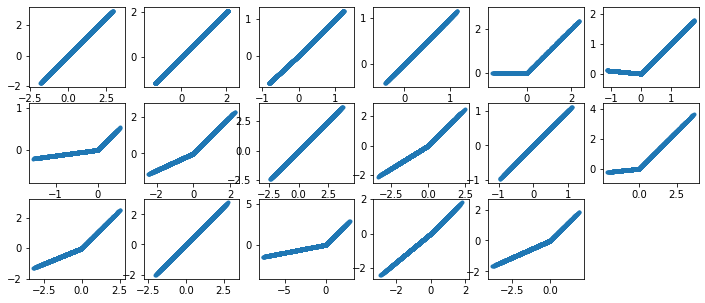

In [78]:
%matplotlib inline
plt.figure(figsize=(12,5))
for i in range(len(layer2.alpha)):
    plt.subplot(3,6, i+1)
    plt.scatter(layer2.input[:,i], layer2.output[:,i], marker='.')
    plt.axis('equal')

In [79]:
layer2.alpha

array([ 0.99840981,  1.00014623,  0.93384973,  1.0002777 ,  0.00943292,
       -0.09687831,  0.1318911 ,  0.45739088,  0.99912233,  0.61523863,
        1.0004057 ,  0.10426474,  0.40706566,  1.00063733,  0.19131596,
        0.82647982,  0.44159279])

In [80]:
layer2.delalpha

array([ 5.74240445e-05,  6.33281527e-06,  2.59459560e-04,  2.35251952e-05,
        4.28085598e-04,  5.72593682e-04,  1.52781425e-03,  2.98025314e-03,
        4.89662265e-04,  2.91822891e-03, -4.24994456e-05, -1.03432353e-03,
       -3.10078851e-03, -4.79207483e-04,  8.05407014e-03,  2.99505195e-03,
        4.24775414e-03])

In [81]:
layer1.weights

array([[ 2.10910909,  1.58478164,  0.04348164, -0.21287111,  0.38726092,
        -0.09629215,  0.71311646, -0.61461498,  0.55819557, -1.43422567,
         0.4719769 , -1.49540569, -1.12535535,  1.01867543, -3.7995322 ,
        -1.32262228,  1.15189916],
       [ 0.28285412, -0.02835331, -0.97734906, -0.57778185, -1.57263437,
        -1.35302834,  0.32509417,  1.74972223, -2.52869133,  1.52946584,
        -0.57443086,  1.41529454, -1.73458659, -1.39861601, -1.48343248,
         1.04005263,  1.66681523]])

In [82]:
np.linalg.norm(layer1.weights, ord=2, axis=0, keepdims=True)

array([[2.12799145, 1.58503526, 0.97831582, 0.6157483 , 1.61961411,
        1.35645047, 0.78372272, 1.85452945, 2.58956795, 2.09672817,
        0.74346016, 2.05895527, 2.06765938, 1.73026772, 4.07884994,
        1.68256921, 2.02611567]])

In [73]:
layer1.bias

array([-1.11132102,  0.60837478,  0.1766686 , -0.04081827,  0.07755345,
        0.30813298,  0.41531958,  0.41820538,  0.17310459,  0.86400476,
       -0.41412325, -0.90746102,  0.4728046 , -0.39021999, -0.67975237,
       -1.78696784, -0.9855883 ])

In [23]:
layer1.adder.bias

AttributeError: 'LinearLayer' object has no attribute 'adder'

In [70]:
layer3.weights

array([[-0.95019016],
       [-0.52905668],
       [ 0.76200699],
       [ 0.1985588 ],
       [ 0.44018608],
       [ 0.87686789],
       [ 0.45368011],
       [ 0.89919087],
       [-0.06328016],
       [-0.87670443],
       [-1.1612273 ],
       [-0.9926028 ],
       [-0.46029577],
       [-0.94039955],
       [ 0.5794993 ],
       [-1.17486196],
       [ 1.10555661]])

In [70]:
1/0.002

500.0

## For 3D output

In [83]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y0 = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
    return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)]
Y1 = np.zeros(X1.shape)
for p in gprms:
    Y1 += gaussian(X1, X2, *p)
    
Y2 = np.cos(np.sqrt((X1-0.5)**2 + X2**2))*2-1.

In [84]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y0 = 2*(Y0 - Y0.min())/(Y0.max() - Y0.min()) -1
Y1 = 2*(Y1 - Y1.min())/(Y1.max() - Y1.min()) -1
Y2 = 2*(Y2 - Y2.min())/(Y2.max() - Y2.min()) -1


x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy0 = Y0.reshape(-1,1)
yy1 = Y1.reshape(-1,1)
yy2 = Y2.reshape(-1,1)

yy = np.concatenate([yy0, yy1, yy2], axis=1)
print(yy.shape)

(2500, 3)


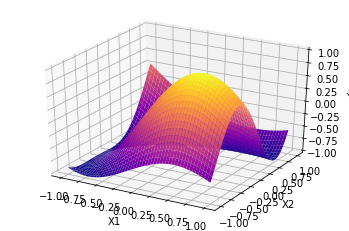

In [86]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y2, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [96]:
optim = tnn.Adam()
net = tnn.AutoForm(new_layers=True)
layer0 = tnn.WeightsLayer(2, 17, optimizer=optim)
layer1 = tnn.BatchNormalization(17, optimizer=optim)
layer2 = PRelu(17, optimizer=optim)
layer3 = tnn.LinearLayer(17, 3, optimizer=optim)

layer2.set_decay_rate(0.002)

In [97]:
try:
    for epoch in range(100000):
        layer1.multiplier.multiplier = layer1.multiplier.multiplier*0 + 0.5
        if epoch < 1000:
            layer2.l1_weight_decay()
        else:
            layer2.l1_weight_recover()

        yout = net.forward(xx)
        
        dy = yout - yy
        dx = net.backward(dy)

        layer3.update()
        layer2.update()
        layer1.update()
        layer0.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
    
except Exception as e:
    raise e

0 Error =  0.42112658988117657
100 Error =  0.06003913928949073
200 Error =  0.037786515103091174
300 Error =  0.029779417058967934
400 Error =  0.01861473316743171
500 Error =  0.013067953194682218
600 Error =  0.01069295147878641
700 Error =  0.009177481664760734
800 Error =  0.008127550706364344
900 Error =  0.007078531958994678
1000 Error =  0.006068652892089915
1100 Error =  0.005408869627433103
1200 Error =  0.004896229986652596
1300 Error =  0.004463093146085043
1400 Error =  0.004119292454770005
1500 Error =  0.003863555379169854
1600 Error =  0.003650970417173266
1700 Error =  0.003503058582011517
1800 Error =  0.0033862653391864054
1900 Error =  0.0032902262814565562
2000 Error =  0.0032505421345978666
2100 Error =  0.0031850655340201475
2200 Error =  0.003151885402536355
2300 Error =  0.0031134442530331443
2400 Error =  0.0031358521632840865
2500 Error =  0.0031396920888518954
2600 Error =  0.0032769747589291172
2700 Error =  0.0031789412351630793
2800 Error =  0.00333792769

KeyboardInterrupt: 

## Visualize Prelu

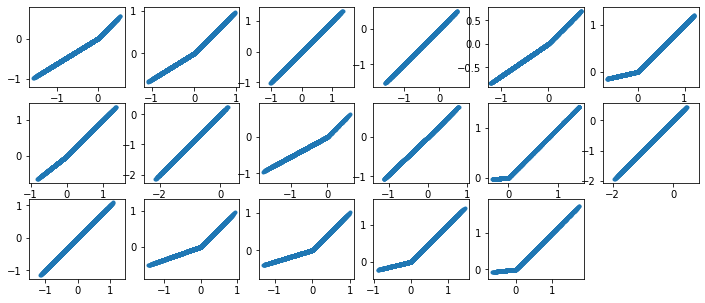

In [98]:
%matplotlib inline
plt.figure(figsize=(12,5))
for i in range(len(layer2.alpha)):
    plt.subplot(3,6, i+1)
    plt.scatter(layer2.input[:,i], layer2.output[:,i], marker='.')
    plt.axis('equal')

In [100]:
layer2.alpha

array([0.61139098, 0.61673272, 1.00148108, 0.99931733, 0.68367688,
       0.22499828, 0.78442756, 1.00008817, 0.53957645, 0.9537062 ,
       0.09908329, 1.00122774, 0.99352475, 0.35133264, 0.30417575,
       0.24285754, 0.10688916])

In [99]:
layer3.weights

array([[-3.48648242,  4.27607306,  2.74562976],
       [-5.5577527 , -0.67523093,  0.15087041],
       [ 0.03956743, -0.08132358, -0.2537407 ],
       [-3.57509326,  0.39093676,  2.47855658],
       [ 0.31836541, -6.38310853, -3.31730529],
       [-2.02053884,  1.17465944,  2.58403816],
       [-3.84268591,  1.63862975,  0.94838331],
       [-0.23735926, -1.6088533 ,  0.6789214 ],
       [ 0.43046691, -2.16655045, -4.1753013 ],
       [-2.17226283, -0.15797373,  0.74849691],
       [-0.10723358,  0.07646032,  3.13392002],
       [-0.08887262,  1.53234657,  0.92988261],
       [-0.16628032, -0.00703991, -0.46054944],
       [ 2.19625857,  2.35869897, -2.05904251],
       [ 2.04128645,  2.38358666, -4.12362162],
       [-1.35592597, -2.12324414, -2.02259132],
       [-0.0557165 , -1.57814084,  1.75597937]])

In [1]:
###_Using Batch Norm effects the splitting/factorization phase of the network

In [ ]:

class BatchNorm_NoScaling(tnn.Layer):

    def __init__(self, io_dim, multiplier=None, adder=None, beta=0.9, epsilon=1e-8, optimizer=SGD()):

        if adder is None:
            self.adder = BiasLayer(io_dim, optimizer=optimizer)
        elif isinstance(adder, np.ndarray):
            self.adder = BiasLayer(io_dim, adder, optimizer)
        else:### This takes Bias Layer
            raise ValueError("The adder is not None or numpy.ndarray")
        layerList.pop(len(layerList) - 1) ### remove adder

        self.beta = beta
        self.epsilon = epsilon

        self.input = None
        self.output = None
        self.del_output = None

        self.moving_mean = 0
        self.moving_var = 0
        self.count = 1

        self.mean = None
        self.std_inv = None
        self.x_norm = None

        self.training = True
        layerList.append(self)


    def forward(self, input):
        self.input = input
        if self.training:
            mean = self.input.mean(axis=0)
            x_mean = self.input-mean
            var = (x_mean**2).mean(axis=0)

            ### Save running averages
            self.moving_mean = self.beta*self.moving_mean + (1-self.beta)*mean
            self.moving_var = self.beta*self.moving_var + (1-self.beta)*var
            ### bias correction
            correction = (1 - self.beta ** self.count)
            self.moving_mean /= correction
            self.moving_var /= correction
            self.count +=1
        else:
            mean, var = self.moving_mean, self.moving_var
            x_mean = self.input-mean

        self.mean = mean
        self.var = var
        self.x_mean = x_mean
        self.std_inv = 1./np.sqrt(var+self.epsilon)

        self.x_norm = self.x_mean*self.std_inv
        self.output = self.adder.forward(self.x_norm*0.5)
        return self.output

    def backward(self, del_output):
        self.del_output = del_output
        N = self.del_output.shape[0]

        del_x_norm = self.adder.backward(del_output)*0.5

        self.del_var = np.sum(del_x_norm * self.x_mean, axis=0) * -.5 * self.std_inv**3
        self.del_mean = np.sum(del_x_norm * - self.std_inv, axis=0) + \
            self.del_var * np.mean(-2. * self.x_mean, axis=0)

        del_input = (del_x_norm * self.std_inv) + (self.del_var * 2 * self.x_mean / N) + (self.del_mean / N)
        return del_input